In [1]:
from pathlib import Path
import sys
PROJ_NAME = "optimal-stopping"

# Locate the Project directory
curr_dir = str(Path.cwd())
start = curr_dir.find(PROJ_NAME)
if start < 0:
    print("ERROR: Project directory not found")
    print("Make sure you have the correct project structure")
    print("and run the simulation from within the project")
proj_pathname = curr_dir[:(start+len(PROJ_NAME))]

# Create path to the project directory
proj_path = Path(proj_pathname)

# Add the project folder to PATH
sys.path.append(proj_pathname)

In [2]:
from bin.data_import import data_init
from bin.data_import import import_dataset_2 as im
from policies.policy import *
from bin.result import Result
from bin.plot_d2 import *
from linreg.lin_reg_model import get_linear_regression_model as get_model
from linreg.lin_reg_model import k_fold_cv as get_error

SIZE = 100
S=["pi3"]
# Initialising data structure
data_init()
sensor_dataset = im(S)[0]
print(len(sensor_dataset))
sensor_dataset = sensor_dataset.iloc[SIZE+1:,:]

264


In [3]:
W=25
theta = 2
B=4

def getNewX(data):
    return data.temperature.values.reshape(-1,1)

def getNewY(data, S=None):
    return data.humidity.values.reshape(-1,1)



In [4]:
from scipy.stats import gamma

shape = 1.2040382652028505
scale = 0.0981466814218533

g = gamma(shape,scale=scale)

In [24]:

data = sensor_dataset.iloc[0:W,:]

# Reshape the temperature and humidity values
init_X = getNewX(data)
# Reshape the sensor values
init_y = getNewY(data, S)
# Build a model to be sent to the Edge Gate
model = get_model(init_X, init_y)
# Evaluate the model
err = get_error(model, init_X, init_y)

err_diff = []
err_storage = [err]
init_err = err
init_model = model

comm_count = 1
comm = [comm_count]

err_sum = err

dataset_length = len(sensor_dataset)

t = 1
currentV = []
futureV = []

comm_count = 1
comm = [comm_count]

i = 1
while (i + W) <= dataset_length:
    
    currentV += [t]
    futureV += [g.cdf(theta-err_sum)*(t+1+B)-B]
    
    # Receive a new datapoint
    data = sensor_dataset.iloc[i:i+W,:]
    X = getNewX(data)
    y = getNewY(data, S)
    # Build a new model with the newly arrived datapoint 
    # and the discarded oldest datapoint
    new_model = get_model(X, y)
    # Evaluate
    new_err = get_error(new_model, X, y)
    err_storage += [new_err]

    init_model_err = get_error(init_model, X, y)
    err_diff += [abs(init_model_err-new_err)]
    
    #DECIDE if we should update or not
    if g.cdf(theta-err_sum)<(t+B)/(t+1+B):
        print(t)
        init_model = new_model
        err_sum = err
        comm_count += 1
        t = 0
    else:
        err_sum += err_diff[-1]
    
    comm += [comm_count]
    t+=1
          
    # Slide the window with 1
    i += 1


6
4
5
4
3
6
6
10
9
12
19
13
3
11
5
3
5


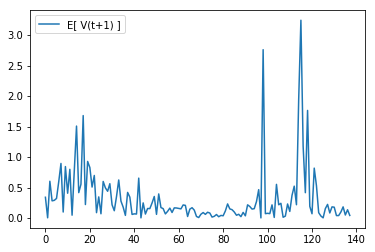

In [27]:
# plt.plot(currentV, label="E[ V(t) ]")
plt.plot(err_diff, label="E[ V(t+1) ]")
plt.legend()
plt.show()

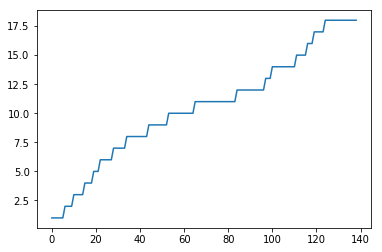

In [26]:
plt.plot(comm)
plt.show()

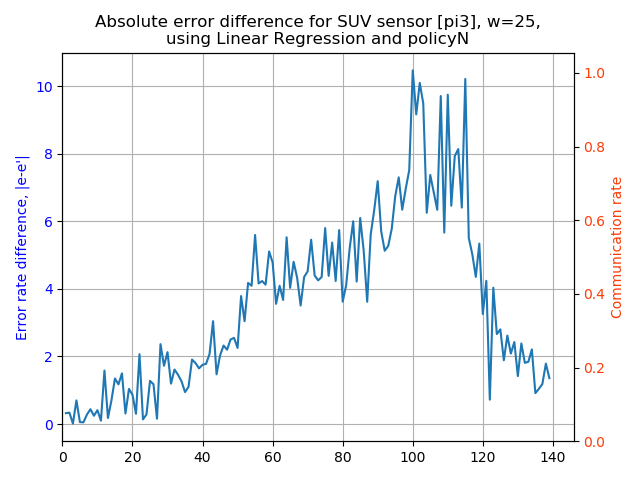

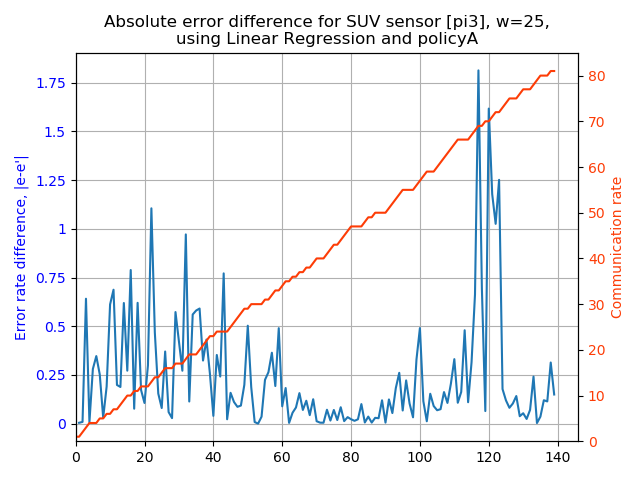

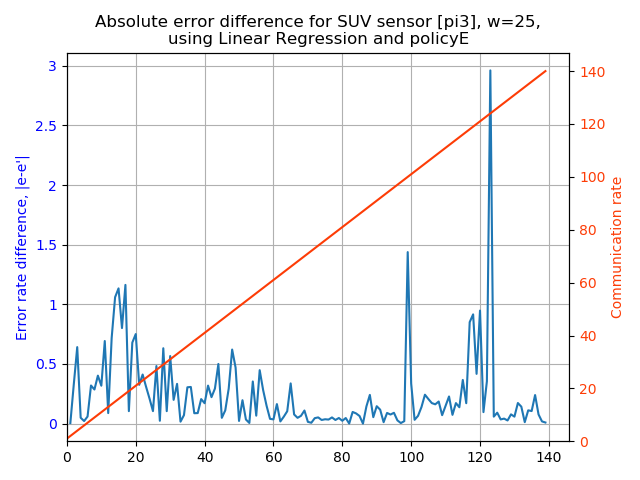

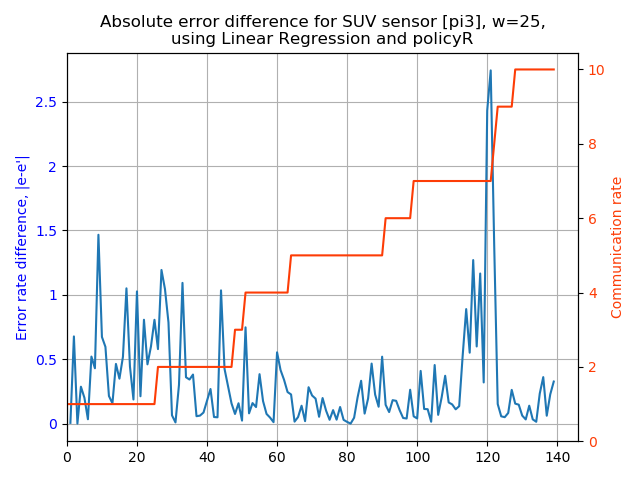

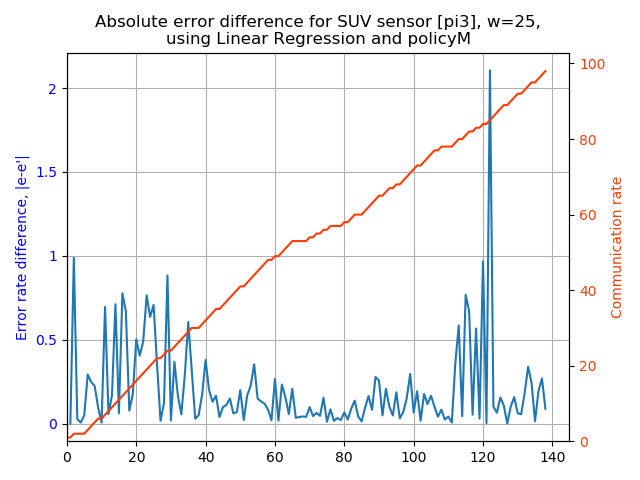

In [180]:
from IPython.display import display, Image
display(Image("../results/dataset_2_lin_reg/policyN/abs_err_diff_pi3_w_25.png", width=400))
display(Image("../results/dataset_2_lin_reg/policyA/abs_err_diff_pi3_w_25.png", width=400))
display(Image("../results/dataset_2_lin_reg/policyE/abs_err_diff_pi3_w_25.png", width=400))
display(Image("../results/dataset_2_lin_reg/policyR/abs_err_diff_pi3_w_25.png", width=400))
display(Image("../results/dataset_2_lin_reg/policyM/abs_err_diff_pi3_w_25.png", width=400))